In [1]:
# initial importing
from eggp import EGGP
from symregg import SymRegg
from reggression import Reggression
from pysr import PySRRegressor
from pyoperon.sklearn import SymbolicRegressor
import bingo.symbolic_regression.symbolic_regressor as bingo # import SymbolicRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("nikuradse_1.csv")
X = df[['r_k','log_Re']].values
y = df['target'].values
df.head()

,r_k,log_Re,target
0,507.0,4.114,0.456
1,507.0,4.230,0.438
2,507.0,4.322,0.417
3,507.0,4.362,0.407
4,507.0,4.362,0.403


In [3]:
def plot_error(expr, X, y):
  x = X
  t = eval(expr.loc[0, 'Parameters'])
  yhat = eval(expr.loc[0, 'Numpy'])
  plt.plot(yhat, y, '.')
  plt.xlabel(r"$\hat{y}$")
  plt.ylabel(r"$y$")

def plot_error_seg(expr, X, y):
  vals = np.unique(X[:,0])
  for xi in vals:
    ix = X[:,0]==xi
    plot_error(expr, X[ix,:], y[ix])

def plot_extrapolate(expr, X, y):
    x1 = np.arange(0, 10, 0.001)
    x0 = np.ones(x1.shape)*126
    x = np.vstack([x0,x1]).T

    for ix in expr.index:
        t = eval(expr.loc[ix, 'Parameters'])
        yhat = eval(expr.loc[ix, 'Numpy'])
        if isinstance(yhat,float) or yhat.shape[0] == 1:
            yhat = np.ones(x.shape[0])*yhat
        plt.plot(x1, yhat, label=f"fit.: {expr.loc[ix, 'Fitness']:.2e} / size: {expr.loc[ix, 'Size']}")


    ix = X[:,0] == 126
    plt.plot(X[ix, 1], y[ix], '.', label="true points")
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$y$")
    plt.legend()
    plt.ylim(0, 10)

In [4]:
def texfmt(x):
    return x

def thetafmt(x):
    return list(map(lambda y: round(float(y),2), x.split(";")))

def parfmt(x):
    if x=="nan" or (isinstance(x, float) and np.isnan(x)):
        return x
    return list(map(lambda y: round(y, 2), eval(x)))
    
def lossfmt(x):
    return f'{x:.2e}'

lossCols = ['loss_train', 'loss_val', 'loss_test', 
            'maxloss', 'R2_train', 'R2_val', 'R2_test', 
            'mdl_train', 'mdl_val', 'mdl_test']
eggpfmt = {'Math': texfmt, 'theta': thetafmt} | { k : lossfmt for k in lossCols }

reggfmt = {'Latex': texfmt,	'Fitness': lossfmt,	'Parameters': parfmt, 'DL': lossfmt}

In [7]:
reg = EGGP(maxSize=25, gen=200, nPop=300, nonterminals="add,sub,mul,div,powerabs,recip", loss="MSE",
           dumpTo="niku1_example.egraph")
reg.fit(X,y)

,gen,200
,nPop,300
,maxSize,25
,nTournament,3
,pc,0.9
,pm,0.3
,nonterminals,"'add,sub,mul,div,powerabs,recip'"
,loss,'MSE'
,optIter,50
,optRepeat,2
,nParams,-1


In [8]:
reg.results.style.format(eggpfmt)

,id,view,Expression,Numpy,Math,theta,size,loss_train,loss_val,loss_test,maxloss,R2_train,R2_val,R2_test,mdl_train,mdl_val,mdl_test
0,0,0,0.5304279005524872,t[0],$$\theta_{0}$$,[0.53],1,2.55e-02,2.55e-02,2.55e-02,2.55e-02,1.89e-15,1.89e-15,1.89e-15,2.55e-02,2.55e-02,2.55e-02
1,1,0,(Abs(x0) ^ -0.15423859206998222),"np.abs(x[:, 0]) ** t[0]",$${\left |x_{0}\right |^{\theta_{0}}}$$,[-0.15],4,5.47e-03,5.47e-03,5.47e-03,5.47e-03,7.86e-01,7.86e-01,7.86e-01,3.30e+00,3.30e+00,3.30e+00
2,2,0,(Abs((-5.506681666674298 / x0)) ^ 0.26266940999453836),"np.abs((t[0] / x[:, 0])) ** t[1]",$${\left |\frac{\theta_{0}}{x_{0}}\right |^{\theta_{1}}}$$,"[-5.51, 0.26]",6,1.31e-03,1.31e-03,1.31e-03,1.31e-03,9.49e-01,9.49e-01,9.49e-01,6.93e+00,6.93e+00,6.93e+00
3,3,0,((1.5632224129910886 * (Abs(x0) ^ -0.2367164301808775)) + -5.686981431383865e-2),"((t[0] * np.abs(x[:, 0]) ** t[1]) + t[2])",$$\left(\left(\theta_{0} \cdot {\left |x_{0}\right |^{\theta_{1}}}\right) + \theta_{2}\right)$$,"[1.56, -0.24, -0.06]",8,1.30e-03,1.30e-03,1.30e-03,1.30e-03,9.49e-01,9.49e-01,9.49e-01,1.13e+01,1.13e+01,1.13e+01
4,4,0,(Abs((x0 / x1)) ^ (-0.11374602520342836 * (Abs(x1) ^ 0.4951616638439577))),"np.abs((x[:, 0] / x[:, 1])) ** (t[0] * np.abs(x[:, 1]) ** t[1])",$${\left |\frac{x_{0}}{x_{1}}\right |^{\left(\theta_{0} \cdot {\left |x_{1}\right |^{\theta_{1}}}\right)}}$$,"[-0.11, 0.5]",11,1.12e-03,1.12e-03,1.12e-03,1.12e-03,9.56e-01,9.56e-01,9.56e-01,1.61e+01,1.61e+01,1.61e+01
5,5,0,Recip((Abs(x1) ^ (Abs(0.24475662900648842) ^ ((Abs(x0) ^ -0.4939192639919545) * x1)))),"np.reciprocal(np.abs(x[:, 1]) ** np.abs(t[0]) ** (np.abs(x[:, 0]) ** t[1] * x[:, 1]))",$$\frac{1}{{\left |x_{1}\right |^{{\left |\theta_{0}\right |^{\left({\left |x_{0}\right |^{\theta_{1}}} \cdot x_{1}\right)}}}}}$$,"[0.24, -0.49]",13,9.90e-04,9.90e-04,9.90e-04,9.90e-04,9.61e-01,9.61e-01,9.61e-01,1.79e+01,1.79e+01,1.79e+01
6,6,0,Recip((Abs(x1) ^ (Abs(-0.24638804452303056) ^ (x1 * (Abs(Recip(x0)) ^ 0.4926734900786686))))),"np.reciprocal(np.abs(x[:, 1]) ** np.abs(t[0]) ** (x[:, 1] * np.abs(np.reciprocal(x[:, 0])) ** t[1]))",$$\frac{1}{{\left |x_{1}\right |^{{\left |\theta_{0}\right |^{\left(x_{1} \cdot {\left |\frac{1}{x_{0}}\right |^{\theta_{1}}}\right)}}}}}$$,"[-0.25, 0.49]",14,9.90e-04,9.90e-04,9.90e-04,9.90e-04,9.61e-01,9.61e-01,9.61e-01,1.97e+01,1.97e+01,1.97e+01
7,7,0,Recip((Abs((x1 + -0.4869538421106512)) ^ (Abs(-0.22852318893075302) ^ (x1 * (Abs(x0) ^ -0.5258813834738519))))),"np.reciprocal(np.abs((x[:, 1] + t[0])) ** np.abs(t[1]) ** (x[:, 1] * np.abs(x[:, 0]) ** t[2]))",$$\frac{1}{{\left |\left(x_{1} + \theta_{0}\right)\right |^{{\left |\theta_{1}\right |^{\left(x_{1} \cdot {\left |x_{0}\right |^{\theta_{2}}}\right)}}}}}$$,"[-0.49, -0.23, -0.53]",15,9.10e-04,9.10e-04,9.10e-04,9.10e-04,9.64e-01,9.64e-01,9.64e-01,2.34e+01,2.34e+01,2.34e+01
8,8,0,Recip((Abs((-0.2800981276471947 * (x1 * x1))) ^ (Abs(-0.30932233764113015) ^ ((Abs(x0) ^ -0.4014597559790582) * x1)))),"np.reciprocal(np.abs((t[0] * (x[:, 1] * x[:, 1]))) ** np.abs(t[1]) ** (np.abs(x[:, 0]) ** t[2] * x[:, 1]))",$$\frac{1}{{\left |\left(\theta_{0} \cdot \left(x_{1} \cdot x_{1}\right)\right)\right |^{{\left |\theta_{1}\right |^{\left({\left |x_{0}\right |^{\theta_{2}}} \cdot x_{1}\right)}}}}}$$,"[-0.28, -0.31, -0.4]",17,8.28e-04,8.28e-04,8.28e-04,8.28e-04,9.68e-01,9.68e-01,9.68e-01,2.51e+01,2.51e+01,2.51e+01
9,9,0,(Abs((Abs((x1 + -1.7264647394658166)) ^ (Abs(Recip(x1)) ^ (Abs(((x1 * x1) / x0)) ^ 0.40866612901658866)))) ^ -1.64926030714769),"np.abs(np.abs((x[:, 1] + t[0])) ** np.abs(np.reciprocal(x[:, 1])) ** np.abs(((x[:, 1] * x[:, 1]) / x[:, 0])) ** t[1]) ** t[2]",$${\left |{\left |\left(x_{1} + \theta_{0}\right)\right |^{{\left |\frac{1}{x_{1}}\right |^{{\left |\frac{\left(x_{1} \cdot x_{1}\right)}{x_{0}}\right |^{\theta_{1}}}}}}}\right |^{\theta_{2}}}$$,"[-1.73, 0.41, -1.65]",20,7.58e-04,7.58e-04,7.58e-04,7.58e-04,9.70e-01,9.70e-01,9.70e-01,3.33e+01,3.33e+01,3.33e+01


In [2]:
egraph = Reggression(dataset="nikuradse_1.csv", loadFrom="niku1_example.egraph", refit=False)

Calculating DL...
Welcome to r🥚ression


In [6]:
egraph.set_simple_output(False)
egraph.top(4, filters=["size < 10"]).style.format(reggfmt)

,Id,Expression,Numpy,Latex,Fitness,Parameters,Size,DL
0,26974,(Abs((x0 / x1)) ^ (t0 * (Abs(x1) ^ t1))),"np.abs((x[:, 0] / x[:, 1])) ** (t[0] * np.abs(x[:, 1]) ** t[1])",\begin{align}{\left|\frac{r_{k}}{log_{Re}}\right|^{\left(\theta_{0} \cdot {\left|log_{Re}\right|^{\theta_{1}}}\right)}}\end{align},-1.12e-03,"[-0.11, 0.5]",9,1.61e+01
1,173811,(Abs((x0 / x1)) ^ (t0 * (Abs(x1) ^ t1))),"np.abs((x[:, 0] / x[:, 1])) ** (t[0] * np.abs(x[:, 1]) ** t[1])",\begin{align}{\left|\frac{r_{k}}{log_{Re}}\right|^{\left(\theta_{0} \cdot {\left|log_{Re}\right|^{\theta_{1}}}\right)}}\end{align},-1.12e-03,"[-0.12, 0.47]",9,1.61e+01
2,156288,(Abs((x0 / x1)) ^ (t0 + (t1 * x1))),"np.abs((x[:, 0] / x[:, 1])) ** (t[0] + (t[1] * x[:, 1]))",\begin{align}{\left|\frac{r_{k}}{log_{Re}}\right|^{\left(\theta_{0} + \left(\theta_{1} \cdot log_{Re}\right)\right)}}\end{align},-1.14e-03,"[-0.12, -0.03]",9,1.75e+01
3,69238,(Abs((x0 / x1)) ^ (t0 * (Abs(t1) ^ x1))),"np.abs((x[:, 0] / x[:, 1])) ** (t[0] * np.abs(t[1]) ** x[:, 1])",\begin{align}{\left|\frac{r_{k}}{log_{Re}}\right|^{\left(\theta_{0} \cdot {\left|\theta_{1}\right|^{log_{Re}}}\right)}}\end{align},-1.15e-03,"[-0.15, 1.1]",9,1.61e+01


In [7]:
egraph.set_simple_output(True)
egraph.top(4).style.format(reggfmt)

,Id,Latex,Fitness
0,181293,\begin{align}\frac{1}{{\left|{\left|\frac{\theta_{0}}{log_{Re}}\right|^{\theta_{1}}}\right|^{{\left|\frac{1}{r_{k}}\right|^{{\left|\frac{{\left|log_{Re}\right|^{\theta_{2}}}}{\frac{1}{\frac{r_{k}}{log_{Re}}}}\right|^{\frac{\theta_{3}}{\left(\theta_{4} + log_{Re}\right)}}}}}}}}\end{align},-5.06e-04
1,191394,\begin{align}\frac{1}{{\left|{\left|\frac{\theta_{0}}{log_{Re}}\right|^{\theta_{1}}}\right|^{{\left|\frac{1}{r_{k}}\right|^{{\left|\frac{{\left|log_{Re}\right|^{\theta_{2}}}}{\left(\left(r_{k} \cdot r_{k}\right) - \left(\theta_{3} + log_{Re}\right)\right)}\right|^{\frac{\theta_{4}}{log_{Re}}}}}}}}}\end{align},-5.32e-04
2,179129,\begin{align}\frac{1}{{\left|{\left|\frac{\theta_{0}}{log_{Re}}\right|^{\theta_{1}}}\right|^{{\left|\frac{1}{r_{k}}\right|^{{\left|\frac{{\left|log_{Re}\right|^{\theta_{2}}}}{\left(\theta_{3} - r_{k}\right)}\right|^{\frac{\theta_{4}}{log_{Re}}}}}}}}}\end{align},-5.32e-04
3,177316,\begin{align}\frac{1}{{\left|{\left|\frac{\theta_{0}}{log_{Re}}\right|^{\theta_{1}}}\right|^{{\left|\frac{1}{r_{k}}\right|^{{\left|\frac{{\left|log_{Re}\right|^{\theta_{2}}}}{\left(\left(r_{k} \cdot r_{k}\right) - log_{Re}\right)}\right|^{\frac{\theta_{3}}{log_{Re}}}}}}}}}\end{align},-5.32e-04


<string>:1: RuntimeWarning: divide by zero encountered in reciprocal
<string>:1: RuntimeWarning: divide by zero encountered in divide
<string>:1: RuntimeWarning: divide by zero encountered in power
<string>:1: RuntimeWarning: overflow encountered in power


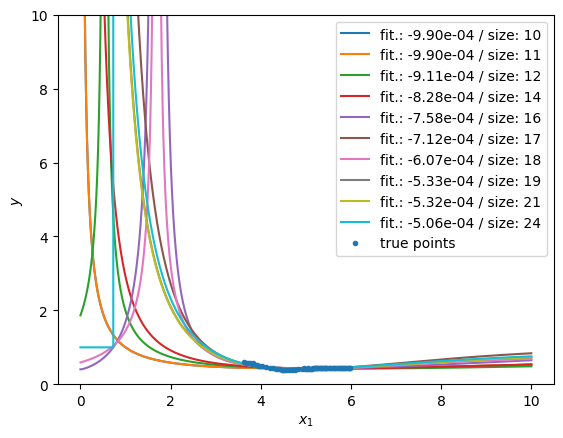

In [12]:
egraph.set_simple_output(False)

ee = egraph.pareto()
plot_extrapolate(ee.iloc[5:,:], X, y)

<string>:1: RuntimeWarning: divide by zero encountered in divide
<string>:1: RuntimeWarning: divide by zero encountered in power
<string>:1: RuntimeWarning: overflow encountered in power
<string>:1: RuntimeWarning: divide by zero encountered in reciprocal


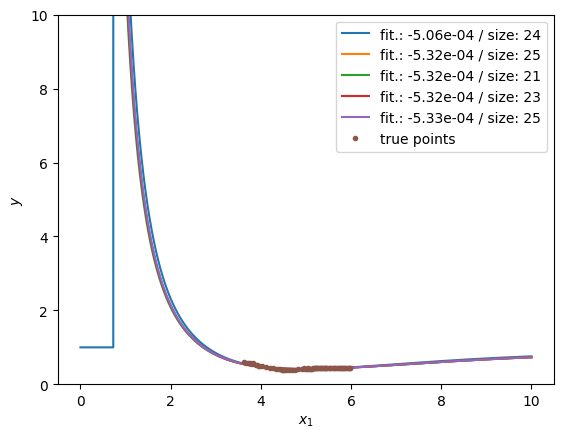

In [13]:
ee = egraph.top(5)
plot_extrapolate(ee, X, y)

In [8]:
# Let's get the top-5
egraph.top(5, filters=["size <= 6"]).style.format(reggfmt)

,Id,Latex,Fitness
0,20363,\begin{align}{\left|\frac{\theta_{0}}{r_{k}}\right|^{\theta_{1}}}\end{align},-1.31e-03
1,11497,\begin{align}\frac{1}{{\left|\frac{\theta_{0}}{r_{k}}\right|^{\theta_{1}}}}\end{align},-1.31e-03
2,52502,\begin{align}\left({\left|\frac{1}{r_{k}}\right|^{\theta_{0}}} \cdot \theta_{1}\right)\end{align},-1.31e-03
3,43971,\begin{align}{\left|\left(\frac{1}{r_{k}} \cdot \theta_{0}\right)\right|^{\theta_{1}}}\end{align},-1.31e-03
4,4130,\begin{align}{\left|\frac{\theta_{0}}{r_{k}}\right|^{\theta_{1}}}\end{align},-1.31e-03


In [9]:
# Let's check the top 5 with size <= 10
egraph.top(5, filters=["size <= 10"]).style.format(reggfmt)

,Id,Latex,Fitness
0,79610,\begin{align}\frac{1}{{\left|log_{Re}\right|^{{\left|\theta_{0}\right|^{\left({\left|r_{k}\right|^{\theta_{1}}} \cdot log_{Re}\right)}}}}}\end{align},-9.90e-04
1,108254,\begin{align}\frac{1}{{\left|log_{Re}\right|^{{\left|log_{Re}\right|^{\left(\theta_{0} \cdot {\left|r_{k}\right|^{\theta_{1}}}\right)}}}}}\end{align},-9.98e-04
2,40178,\begin{align}\frac{1}{{\left|log_{Re}\right|^{{\left|\theta_{0}\right|^{{\left|\frac{log_{Re}}{r_{k}}\right|^{\theta_{1}}}}}}}}\end{align},-1.10e-03
3,56709,\begin{align}\frac{1}{{\left|{\left|\frac{log_{Re}}{r_{k}}\right|^{\theta_{0}}}\right|^{{\left|log_{Re}\right|^{\theta_{1}}}}}}\end{align},-1.12e-03
4,212324,\begin{align}\frac{1}{{\left|{\left|\frac{r_{k}}{log_{Re}}\right|^{{\left|log_{Re}\right|^{\theta_{0}}}}}\right|^{\theta_{1}}}}\end{align},-1.12e-03


In [10]:
# Now let's retrieve the top 5 with size <= 10 and not having the pattern |v0|^v1
(egraph
 .top(5, filters=["size <= 6"], 
      pattern="(v0 |**| v1)", 
      negate=True)
 .style.format(reggfmt))

,Id,Latex,Fitness
0,65332,\begin{align}\frac{\theta_{0}}{{\left|\frac{1}{r_{k}}\right|^{\theta_{1}}}}\end{align},-1.31e-03
1,3873,\begin{align}\frac{1}{\left(\left(r_{k} \cdot \theta_{0}\right) + \theta_{1}\right)}\end{align},-3.68e-03
2,2274,\begin{align}\left(\frac{1}{\left(r_{k} + \theta_{0}\right)} \cdot \theta_{1}\right)\end{align},-3.68e-03
3,544,\begin{align}\left(\frac{1}{\left(r_{k} + \theta_{0}\right)} \cdot \theta_{1}\right)\end{align},-3.68e-03
4,364,\begin{align}\frac{1}{\left(\theta_{0} - \left(r_{k} \cdot \theta_{1}\right)\right)}\end{align},-3.68e-03


In [11]:
# Now let's find expressions with this pattern at the root (so the root should be *)
(egraph
 .top(5, 
      filters=["size <= 10"],
      pattern="x0 * v1", 
      isRoot=True)
 .style.format(reggfmt))

,Id,Latex,Fitness
0,4771,\begin{align}\left(r_{k} \cdot {\left|\theta_{0}\right|^{r_{k}}}\right)\end{align},-1.76e-01
1,86,\begin{align}\left(r_{k} \cdot \theta_{0}\right)\end{align},-2.45e-01
2,7932,\begin{align}\left(r_{k} \cdot \left({\left|r_{k}\right|^{\theta_{0}}} \cdot \theta_{1}\right)\right)\end{align},-3.07e-01
3,6,\begin{align}\left(r_{k} \cdot log_{Re}\right)\end{align},-1.19e+06
4,89174,\begin{align}\left(r_{k} \cdot \frac{\theta_{0}}{\frac{\left(log_{Re} \cdot \theta_{1}\right)}{r_{k}}}\right)\end{align},-2.63e+07


In [12]:
# let's test other filters
(egraph
 .top(5, 
      filters=["size < 10", "parameters > 1", "cost < 15"], 
      criteria="dl")
 .style.format(reggfmt))

,Id,Latex,Fitness
0,2198,\begin{align}{\left|\theta_{0}\right|^{{\left|r_{k}\right|^{\theta_{1}}}}}\end{align},-2.18e-03
1,150193,\begin{align}{\left|\theta_{0}\right|^{{\left|r_{k}\right|^{\theta_{1}}}}}\end{align},-2.18e-03
2,9829,\begin{align}{\left|{\left|r_{k}\right|^{\theta_{0}}}\right|^{\theta_{1}}}\end{align},-5.47e-03
3,58404,\begin{align}{\left|{\left|log_{Re}\right|^{\theta_{0}}}\right|^{\theta_{1}}}\end{align},-2.48e-02
4,14497,\begin{align}{\left|{\left|log_{Re}\right|^{\theta_{0}}}\right|^{\theta_{1}}}\end{align},-2.48e-02


In [13]:
# query for the top patterns by the following criteria
# from the top 5000 expressions, with at least 1000 of frequency
# show the top 25 distributions sorted by avg. fitness 
# and with size between 8 and 15
dist = egraph.distribution(filters=["size < 8"], 
                           limitedAt=100, dsc=True, 
                           byFitness=True, atLeast=50, 
                           fromTop=1000)
dist.iloc[0:100:20].style.format(reggfmt)

,Pattern,Count,AvgFit
0,Recip(((v0 |^| t1) |^| v1)),163,-0.000628
20,Recip(((t0 + v0) |^| v1)),191,-0.000697
40,Recip(((v0 + x1) |^| v1)),69,-0.000730


In [13]:
egraph.countPattern("v0 |**| v1")

'v0 |**| v1 appears in 0 equations.'

In [7]:
# inspect the subtrees
egraph.subtrees(60394).style.format(reggfmt)

,Id,Expression,Numpy,Latex,Fitness,Parameters,Size,DL
0,60394,(Abs((t0 / (((Abs(t1) ^ x1) * x0) * ((t2 / x1) - (x0 + t3))))) ^ t4),"np.abs((t[0] / ((np.abs(t[1]) ** x[:, 1] * x[:, 0]) * ((t[2] / x[:, 1]) - (x[:, 0] + t[3]))))) ** t[4]",\begin{align}{\left|\frac{\theta_{0}}{\left(\left({\left|\theta_{1}\right|^{log_{Re}}} \cdot r_{k}\right) \cdot \left(\frac{\theta_{2}}{log_{Re}} - \left(r_{k} + \theta_{3}\right)\right)\right)}\right|^{\theta_{4}}}\end{align},nan,nan,17,nan
1,60393,(t0 / (((Abs(t1) ^ x1) * x0) * ((t2 / x1) - (x0 + t3)))),"(t[0] / ((np.abs(t[1]) ** x[:, 1] * x[:, 0]) * ((t[2] / x[:, 1]) - (x[:, 0] + t[3]))))",\begin{align}\frac{\theta_{0}}{\left(\left({\left|\theta_{1}\right|^{log_{Re}}} \cdot r_{k}\right) \cdot \left(\frac{\theta_{2}}{log_{Re}} - \left(r_{k} + \theta_{3}\right)\right)\right)}\end{align},nan,nan,15,nan
2,1662,t0,t[0],\begin{align}\theta_{0}\end{align},nan,nan,1,nan
3,1630,t0,t[0],\begin{align}\theta_{0}\end{align},nan,nan,1,nan
4,60392,(((Abs(t0) ^ x1) * x0) * ((t1 / x1) - (x0 + t2))),"((np.abs(t[0]) ** x[:, 1] * x[:, 0]) * ((t[1] / x[:, 1]) - (x[:, 0] + t[2])))",\begin{align}\left(\left({\left|\theta_{0}\right|^{log_{Re}}} \cdot r_{k}\right) \cdot \left(\frac{\theta_{1}}{log_{Re}} - \left(r_{k} + \theta_{2}\right)\right)\right)\end{align},nan,nan,13,nan
5,2469,((Abs(t0) ^ x1) * x0),"(np.abs(t[0]) ** x[:, 1] * x[:, 0])",\begin{align}\left({\left|\theta_{0}\right|^{log_{Re}}} \cdot r_{k}\right)\end{align},nan,nan,5,nan
6,60391,((t0 / x1) - (x0 + t1)),"((t[0] / x[:, 1]) - (x[:, 0] + t[1]))",\begin{align}\left(\frac{\theta_{0}}{log_{Re}} - \left(r_{k} + \theta_{1}\right)\right)\end{align},nan,nan,7,nan
7,1680,(Abs(t0) ^ x1),"np.abs(t[0]) ** x[:, 1]",\begin{align}{\left|\theta_{0}\right|^{log_{Re}}}\end{align},nan,nan,3,nan
8,0,x0,"x[:, 0]",\begin{align}r_{k}\end{align},-4.47e+04,[],1,4.47e+04
9,1631,t0,t[0],\begin{align}\theta_{0}\end{align},nan,nan,1,nan


In [9]:
# (re) optimize the parameters
egraph.optimize(60392).style.format(reggfmt)

,Id,Expression,Numpy,Latex,Fitness,Parameters,Size,DL
0,60392,(((Abs(t0) ^ x1) * x0) * ((t1 / x1) - (x0 + t2))),"((np.abs(t[0]) ** x[:, 1] * x[:, 0]) * ((t[1] / x[:, 1]) - (x[:, 0] + t[2])))",\begin{align}\left(\left({\left|\theta_{0}\right|^{log_{Re}}} \cdot r_{k}\right) \cdot \left(\frac{\theta_{1}}{log_{Re}} - \left(r_{k} + \theta_{2}\right)\right)\right)\end{align},-2.33e+09,"[0.87, -0.38, -0.59]",13,2.33e+09


In [10]:
# insert a new expression
egraph.insert("t0 + log(x1) * x0 * t1").style.format(reggfmt)

,Id,Expression,Numpy,Latex,Fitness,Parameters,Size,DL
0,219811,(t0 + ((Log(x1) * x0) * t1)),"(t[0] + ((np.log(x[:, 1]) * x[:, 0]) * t[1]))",\begin{align}\left(\theta_{0} + \left(\left(\operatorname{log}(log_{Re}) \cdot r_{k}\right) \cdot \theta_{1}\right)\right)\end{align},-8.55e-03,"[0.64, -0.0]",8,1.43e+01


In [12]:
# show the Pareto front
pareto = egraph.pareto(byFitness=False)
pareto.style.format(reggfmt)

,Id,Expression,Numpy,Latex,Fitness,Parameters,Size,DL
0,2,t0,t[0],\begin{align}\theta_{0}\end{align},-2.55e-02,[0.53],1,2.55e-02
1,102,(Abs(x0) ^ t0),"np.abs(x[:, 0]) ** t[0]",\begin{align}{\left|r_{k}\right|^{\theta_{0}}}\end{align},-5.47e-03,[-0.15],3,3.30e+00
3,2198,(Abs(t0) ^ (Abs(x0) ^ t1)),"np.abs(t[0]) ** np.abs(x[:, 0]) ** t[1]",\begin{align}{\left|\theta_{0}\right|^{{\left|r_{k}\right|^{\theta_{1}}}}}\end{align},-2.18e-03,"[-0.89, 0.4]",5,5.50e+00
4,69052,Recip(Recip((x1 * Recip(x1)))),"np.reciprocal(np.reciprocal((x[:, 1] * np.reciprocal(x[:, 1]))))",\begin{align}\frac{1}{\frac{1}{\left(log_{Re} \cdot \frac{1}{log_{Re}}\right)}}\end{align},-2.46e-01,[],6,6.84e+00
5,103910,(Abs((Abs((Abs(x1) ^ t0)) ^ t1)) ^ t2),"np.abs(np.abs(np.abs(x[:, 1]) ** t[0]) ** t[1]) ** t[2]",\begin{align}{\left|{\left|{\left|log_{Re}\right|^{\theta_{0}}}\right|^{\theta_{1}}}\right|^{\theta_{2}}}\end{align},-2.48e-02,"[1.24, -0.54, 0.6]",7,7.72e+00
6,49108,Recip((Abs(x1) ^ (Abs(Recip(x1)) ^ Recip(x1)))),"np.reciprocal(np.abs(x[:, 1]) ** np.abs(np.reciprocal(x[:, 1])) ** np.reciprocal(x[:, 1]))",\begin{align}\frac{1}{{\left|log_{Re}\right|^{{\left|\frac{1}{log_{Re}}\right|^{\frac{1}{log_{Re}}}}}}}\end{align},-7.06e-02,[],8,8.86e+00
7,71205,(Abs((Abs(t0) ^ (Abs(t1) ^ (Abs(x1) ^ t2)))) ^ t3),"np.abs(np.abs(t[0]) ** np.abs(t[1]) ** np.abs(x[:, 1]) ** t[2]) ** t[3]",\begin{align}{\left|{\left|\theta_{0}\right|^{{\left|\theta_{1}\right|^{{\left|log_{Re}\right|^{\theta_{2}}}}}}}\right|^{\theta_{3}}}\end{align},-2.53e-02,"[-0.39, 0.66, -0.5, 0.82]",9,9.91e+00
8,100318,(Abs((Abs(t0) ^ (Abs(Recip((Abs(t1) ^ x0))) ^ t2))) ^ t3),"np.abs(np.abs(t[0]) ** np.abs(np.reciprocal(np.abs(t[1]) ** x[:, 0])) ** t[2]) ** t[3]",\begin{align}{\left|{\left|\theta_{0}\right|^{{\left|\frac{1}{{\left|\theta_{1}\right|^{r_{k}}}}\right|^{\theta_{2}}}}}\right|^{\theta_{3}}}\end{align},-9.32e-03,"[-0.35, -0.99, 0.34, 0.44]",10,1.39e+01
10,81363,(Abs((Abs(x1) ^ (Abs(Recip(x1)) ^ (Abs(t0) ^ (Abs(x1) ^ t1))))) ^ t2),"np.abs(np.abs(x[:, 1]) ** np.abs(np.reciprocal(x[:, 1])) ** np.abs(t[0]) ** np.abs(x[:, 1]) ** t[1]) ** t[2]",\begin{align}{\left|{\left|log_{Re}\right|^{{\left|\frac{1}{log_{Re}}\right|^{{\left|\theta_{0}\right|^{{\left|log_{Re}\right|^{\theta_{1}}}}}}}}}\right|^{\theta_{2}}}\end{align},-2.47e-02,"[-15.66, -0.77, -14.25]",12,1.67e+01
11,9381,(Abs((Abs((x0 * t0)) ^ t1)) ^ (t2 * (Abs(t3) ^ (x0 * t4)))),"np.abs(np.abs((x[:, 0] * t[0])) ** t[1]) ** (t[2] * np.abs(t[3]) ** (x[:, 0] * t[4]))",\begin{align}{\left|{\left|\left(r_{k} \cdot \theta_{0}\right)\right|^{\theta_{1}}}\right|^{\left(\theta_{2} \cdot {\left|\theta_{3}\right|^{\left(r_{k} \cdot \theta_{4}\right)}}\right)}}\end{align},-1.30e-03,"[-0.19, -0.52, 0.49, 0.92, -0.0]",13,1.80e+01


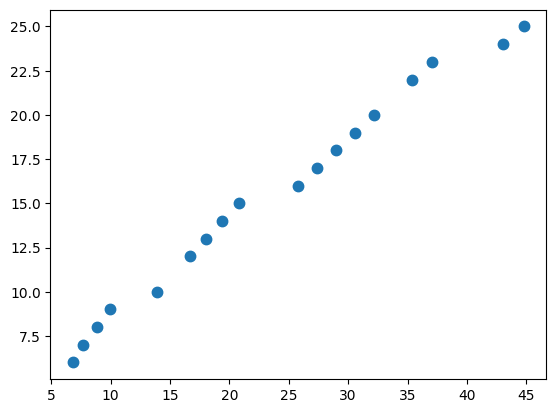

In [13]:
# plot the pareto front
pareto = egraph.pareto(byFitness=False)
plt.plot(pareto.DL.iloc[3:], pareto.Size.iloc[3:], '.', markersize=15)#, xlabel="DL", )

In [14]:
expr = egraph.insert("x0 ** (t0 + sqrt(x1))")
egraph.extractPattern(expr.Id.values[0])

,Pattern,Count,AvgFit
0,(x0 ^ (t0 + Sqrt(x1))),1,0.0
1,(x0 ^ (t0 + Sqrt(v0))),1,0.0
2,(x0 ^ (t0 + v0)),1,0.0
3,(x0 ^ (v0 + Sqrt(x1))),1,0.0
4,(x0 ^ (v0 + Sqrt(v1))),1,0.0
5,(x0 ^ (v0 + v1)),1,0.0
6,(x0 ^ v0),1,0.0
7,(v0 ^ (t0 + Sqrt(x1))),1,0.0
8,(v0 ^ (t0 + Sqrt(v1))),1,0.0
9,(v0 ^ (t0 + v1)),1,0.0


In [15]:
egraph.distributionOfTokens(500)

,Pattern,Count,AvgFit
0,x0,953,-0.000319
1,x1,2117,-0.000144
2,t0,505,-0.000602
3,t1,497,-0.000608
4,t2,496,-0.000608
5,t3,462,-0.000608
6,t4,297,-0.000611
7,t5,89,-0.000621
8,t6,7,-0.000628
9,Recip(v0),997,-0.000305


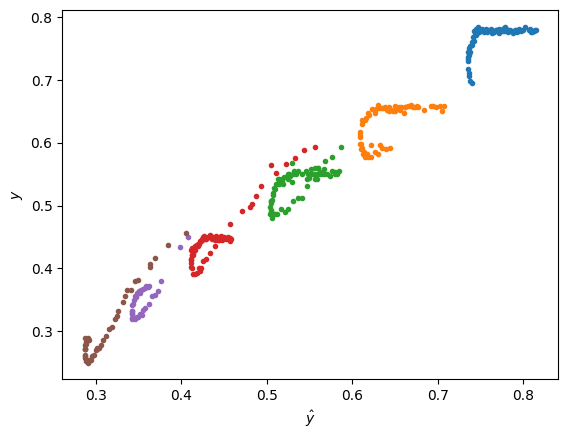

In [16]:
top = egraph.top(1)
plot_error_seg(top, X, y)

In [14]:
# let's run other algorithms, starting with PySR
regPySR = PySRRegressor(verbosity=0)
regPySR.fit(X, y)
f = open("equations.pysr", "w")
for eq in regPySR.equations_.equation:
  print(f"{eq},,1.0", file=f)
f.close()

/home/olivetti/.local/pyenv/lib/python3.13/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [15]:
# now Operon
regOp = SymbolicRegressor()
regOp.fit(X, y)
f = open("equations.operon", "w")
for eq in regOp.pareto_front_:
  eqstr = regOp.get_model_string(eq['tree'])
  print(f"{eqstr},,1.0", file=f)
f.close()

In [16]:
# and Bingo
regBingo = bingo.SymbolicRegressor(max_time=60)
regBingo.fit(X, y)
f = open("equations.bingo", "w")
for eq in regBingo.best_pop:
  print(f"{eq},,1.0", file=f)
f.close()

/home/olivetti/.local/pyenv/lib/python3.13/site-packages/scipy/optimize/_minpack_py.py:497: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
/home/olivetti/.local/pyenv/lib/python3.13/site-packages/bingo/evaluation/fitness_function.py:25: RuntimeWarning: overflow encountered in square
  return np.mean(np.square(vector))
/home/olivetti/.local/pyenv/lib/python3.13/site-packages/scipy/optimize/_minpack_py.py:497: RuntimeWarning: invalid value encountered in matmul
  cov_x = invR @ invR.T


In [17]:
egraph.importFromCSV("equations.bingo", True)
egraph.importFromCSV("equations.operon", True)
egraph.importFromCSV("equations.pysr", True)

''

In [18]:
# let's save the results
egraph.save("newegg.egg");
# and reload to rebuild the database
egraph = Reggression(dataset="nikuradse_1.csv", loadFrom="newegg.egg", refit=True)

Calculating DL...
Welcome to r🥚ression


In [19]:
egraph.top().style.format(reggfmt)

,Id,Expression,Numpy,Latex,Fitness,Parameters,Size,DL
0,181293,Recip((Abs((Abs((t0 / x1)) ^ t1)) ^ (Abs(Recip(x0)) ^ (Abs(((Abs(x1) ^ t2) / Recip((x0 / x1)))) ^ (t3 / (t4 + x1)))))),"np.reciprocal(np.abs(np.abs((t[0] / x[:, 1])) ** t[1]) ** np.abs(np.reciprocal(x[:, 0])) ** np.abs((np.abs(x[:, 1]) ** t[2] / np.reciprocal((x[:, 0] / x[:, 1])))) ** (t[3] / (t[4] + x[:, 1])))",\begin{align}\frac{1}{{\left|{\left|\frac{\theta_{0}}{log_{Re}}\right|^{\theta_{1}}}\right|^{{\left|\frac{1}{r_{k}}\right|^{{\left|\frac{{\left|log_{Re}\right|^{\theta_{2}}}}{\frac{1}{\frac{r_{k}}{log_{Re}}}}\right|^{\frac{\theta_{3}}{\left(\theta_{4} + log_{Re}\right)}}}}}}}}\end{align},-5.18e-04,"[-2.77, -2.48, -0.34, -3.76, -0.54]",24,4.67e+01
1,169578,(Abs(Recip((Abs(((t0 / x1) + Recip(Recip((t1 / x0))))) ^ (Abs(Recip(x0)) ^ (Abs(((Abs(x1) ^ t2) / x0)) ^ (t3 / x1)))))) ^ t4),"np.abs(np.reciprocal(np.abs(((t[0] / x[:, 1]) + np.reciprocal(np.reciprocal((t[1] / x[:, 0]))))) ** np.abs(np.reciprocal(x[:, 0])) ** np.abs((np.abs(x[:, 1]) ** t[2] / x[:, 0])) ** (t[3] / x[:, 1]))) ** t[4]",\begin{align}{\left|\frac{1}{{\left|\left(\frac{\theta_{0}}{log_{Re}} + \frac{1}{\frac{1}{\frac{\theta_{1}}{r_{k}}}}\right)\right|^{{\left|\frac{1}{r_{k}}\right|^{{\left|\frac{{\left|log_{Re}\right|^{\theta_{2}}}}{r_{k}}\right|^{\frac{\theta_{3}}{log_{Re}}}}}}}}}\right|^{\theta_{4}}}\end{align},-5.24e-04,"[2.75, -0.35, 1.38, 4.33, -2.42]",25,4.86e+01
2,188339,Recip((Abs((Abs((t0 / ((t1 * x1) + t2))) ^ t3)) ^ (Abs(Recip(x0)) ^ (Abs(((Abs(x1) ^ t4) / x0)) ^ (t5 / x1))))),"np.reciprocal(np.abs(np.abs((t[0] / ((t[1] * x[:, 1]) + t[2]))) ** t[3]) ** np.abs(np.reciprocal(x[:, 0])) ** np.abs((np.abs(x[:, 1]) ** t[4] / x[:, 0])) ** (t[5] / x[:, 1]))",\begin{align}\frac{1}{{\left|{\left|\frac{\theta_{0}}{\left(\left(\theta_{1} \cdot log_{Re}\right) + \theta_{2}\right)}\right|^{\theta_{3}}}\right|^{{\left|\frac{1}{r_{k}}\right|^{{\left|\frac{{\left|log_{Re}\right|^{\theta_{4}}}}{r_{k}}\right|^{\frac{\theta_{5}}{log_{Re}}}}}}}}}\end{align},-5.32e-04,"[2.5, -0.83, -0.26, -2.54, 1.35, 4.26]",23,4.78e+01
3,197970,Recip((Abs((Abs((t0 / x1)) ^ t1)) ^ (Abs(Recip(x0)) ^ (Abs(((Abs(x1) ^ t2) / ((x0 * x0) - (x1 + x1)))) ^ (t3 / x1))))),"np.reciprocal(np.abs(np.abs((t[0] / x[:, 1])) ** t[1]) ** np.abs(np.reciprocal(x[:, 0])) ** np.abs((np.abs(x[:, 1]) ** t[2] / ((x[:, 0] * x[:, 0]) - (x[:, 1] + x[:, 1])))) ** (t[3] / x[:, 1]))",\begin{align}\frac{1}{{\left|{\left|\frac{\theta_{0}}{log_{Re}}\right|^{\theta_{1}}}\right|^{{\left|\frac{1}{r_{k}}\right|^{{\left|\frac{{\left|log_{Re}\right|^{\theta_{2}}}}{\left(\left(r_{k} \cdot r_{k}\right) - \left(log_{Re} + log_{Re}\right)\right)}\right|^{\frac{\theta_{3}}{log_{Re}}}}}}}}}\end{align},-5.32e-04,"[-2.74, -2.5, 2.68, 2.06]",25,5.49e+01
4,179129,Recip((Abs((Abs((t0 / x1)) ^ t1)) ^ (Abs(Recip(x0)) ^ (Abs(((Abs(x1) ^ t2) / (t3 - x0))) ^ (t4 / x1))))),"np.reciprocal(np.abs(np.abs((t[0] / x[:, 1])) ** t[1]) ** np.abs(np.reciprocal(x[:, 0])) ** np.abs((np.abs(x[:, 1]) ** t[2] / (t[3] - x[:, 0]))) ** (t[4] / x[:, 1]))",\begin{align}\frac{1}{{\left|{\left|\frac{\theta_{0}}{log_{Re}}\right|^{\theta_{1}}}\right|^{{\left|\frac{1}{r_{k}}\right|^{{\left|\frac{{\left|log_{Re}\right|^{\theta_{2}}}}{\left(\theta_{3} - r_{k}\right)}\right|^{\frac{\theta_{4}}{log_{Re}}}}}}}}}\end{align},-5.33e-04,"[2.71, -2.44, 1.31, 0.91, 4.07]",21,4.09e+01


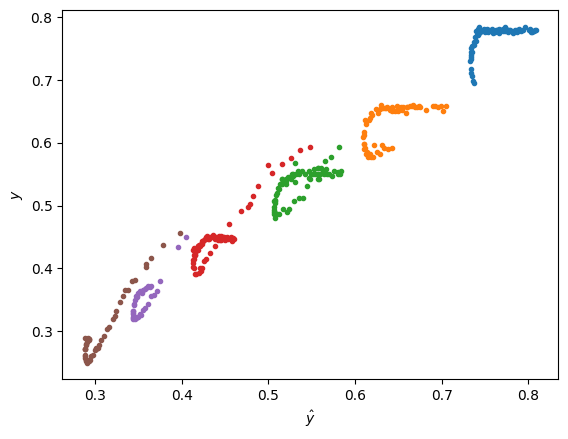

In [20]:
top = egraph.top(1)
plot_error_seg(top, X, y)

In [22]:
reg_graph = Reggression(dataset="nikuradse_1.csv", parseCSV="equations.operon")
reg_graph.importFromCSV("equations.bingo", True)
reg_graph.importFromCSV("equations.pysr", True)

Calculating DL...
Welcome to r🥚ression


''

In [23]:
reg_graph.save("seed.egraph")
reg_graph = Reggression(dataset="nikuradse_1.csv", loadFrom="seed.egraph", refit=True)
reg_graph.save("seed.egraph")
reg_graph.top(5).style.format(reggfmt)

Calculating DL...
Welcome to r🥚ression


,Id,Expression,Numpy,Latex,Fitness,Parameters,Size,DL
0,867,(((x1 - (t0 / x1)) / (x1 + (x0 / x1))) + (t1 / (x1 + t2))),"(((x[:, 1] - (t[0] / x[:, 1])) / (x[:, 1] + (x[:, 0] / x[:, 1]))) + (t[1] / (x[:, 1] + t[2])))",\begin{align}\left(\frac{\left(log_{Re} - \frac{\theta_{0}}{log_{Re}}\right)}{\left(log_{Re} + \frac{r_{k}}{log_{Re}}\right)} + \frac{\theta_{1}}{\left(log_{Re} + \theta_{2}\right)}\right)\end{align},-8.11e-04,"[5.4, 1.08, -1.24]",17,3.05e+01
1,861,((x1 / (((x0 / x1) + t0) + x1)) + (t1 / (x1 + t2))),"((x[:, 1] / (((x[:, 0] / x[:, 1]) + t[0]) + x[:, 1])) + (t[1] / (x[:, 1] + t[2])))",\begin{align}\left(\frac{log_{Re}}{\left(\left(\frac{r_{k}}{log_{Re}} + \theta_{0}\right) + log_{Re}\right)} + \frac{\theta_{1}}{\left(log_{Re} + \theta_{2}\right)}\right)\end{align},-8.84e-04,"[2.07, 1.34, -0.05]",15,2.41e+01
2,852,(((x1 / ((x0 / x1) + t0)) + t1) + (t2 / x1)),"(((x[:, 1] / ((x[:, 0] / x[:, 1]) + t[0])) + t[1]) + (t[2] / x[:, 1]))",\begin{align}\left(\left(\frac{log_{Re}}{\left(\frac{r_{k}}{log_{Re}} + \theta_{0}\right)} + \theta_{1}\right) + \frac{\theta_{2}}{log_{Re}}\right)\end{align},-8.84e-04,"[7.16, -0.1, 1.83]",13,2.09e+01
3,884,((t0 / (x1 + (x1 + t1))) + (((t2 / x1) + x1) / (((x0 / x1) * t3) + x1))),"((t[0] / (x[:, 1] + (x[:, 1] + t[1]))) + (((t[2] / x[:, 1]) + x[:, 1]) / (((x[:, 0] / x[:, 1]) * t[3]) + x[:, 1])))",\begin{align}\left(\frac{\theta_{0}}{\left(log_{Re} + \left(log_{Re} + \theta_{1}\right)\right)} + \frac{\left(\frac{\theta_{2}}{log_{Re}} + log_{Re}\right)}{\left(\left(\frac{r_{k}}{log_{Re}} \cdot \theta_{3}\right) + log_{Re}\right)}\right)\end{align},-1.20e-03,"[2.68, -1.0, -1.64, 1.43]",21,3.76e+01
4,369,((t0 / (x0 + x1)) + t1),"((t[0] / (x[:, 0] + x[:, 1])) + t[1])",\begin{align}\left(\frac{\theta_{0}}{\left(r_{k} + log_{Re}\right)} + \theta_{1}\right)\end{align},-3.11e-03,"[8.71, 0.36]",7,1.13e+01


In [5]:
reg = EGGP(maxSize=15, gen=200, nPop=100, loss="MSE",
           nonterminals="add,sub,mul,div,powerabs,recip",            
           loadFrom="seed.egraph", dumpTo="final.egraph")
reg.fit(X,y)

,gen,200
,nPop,100
,maxSize,15
,nTournament,3
,pc,0.9
,pm,0.3
,nonterminals,"'add,sub,mul,div,powerabs,recip'"
,loss,'MSE'
,optIter,50
,optRepeat,2
,nParams,-1


In [6]:
reg.results.style.format(reggfmt)

,id,view,Expression,Numpy,Math,theta,size,loss_train,loss_val,loss_test,maxloss,R2_train,R2_val,R2_test,mdl_train,mdl_val,mdl_test
0,0,0,0.5304279005524856,t[0],$$\theta_{0}$$,0.5304279005524856,1,0.025533,0.025533,0.025533,0.025533,0.000000,0.000000,0.000000,0.025533,0.025533,0.025533
1,1,0,(Abs(x0) ^ -0.15423935780391132),"np.abs(x[:, 0]) ** t[0]",$${\left |x_{0}\right |^{\theta_{0}}}$$,-0.15423935780391132,4,0.005466,0.005466,0.005466,0.005466,0.785925,0.785925,0.785925,3.301303,3.301303,3.301303
2,2,0,(1.5653420884858704 * (Abs(x0) ^ -0.2626682640903504)),"(t[0] * np.abs(x[:, 0]) ** t[1])",$$\left(\theta_{0} \cdot {\left |x_{0}\right |^{\theta_{1}}}\right)$$,1.5653420884858704;-0.2626682640903504,6,0.001309,0.001309,0.001309,0.001309,0.948745,0.948745,0.948745,6.932781,6.932781,6.932781
3,3,0,((Abs((-0.1594430827542368 * x0)) ^ -0.24270982621414017) + -4.285006710763043e-2),"(np.abs((t[0] * x[:, 0])) ** t[1] + t[2])",$$\left({\left |\left(\theta_{0} \cdot x_{0}\right)\right |^{\theta_{1}}} + \theta_{2}\right)$$,-0.1594430827542368;-0.24270982621414017;-4.285006710763043e-2,8,0.001304,0.001304,0.001304,0.001304,0.948925,0.948925,0.948925,11.267369,11.267369,11.267369
4,4,0,(Abs((x0 / x1)) ^ (-0.11586354273135421 * (Abs(x1) ^ 0.4838897272177891))),"np.abs((x[:, 0] / x[:, 1])) ** (t[0] * np.abs(x[:, 1]) ** t[1])",$${\left |\frac{x_{0}}{x_{1}}\right |^{\left(\theta_{0} \cdot {\left |x_{1}\right |^{\theta_{1}}}\right)}}$$,-0.11586354273135421;0.4838897272177891,11,0.001124,0.001124,0.001124,0.001124,0.955971,0.955971,0.955971,16.126959,16.126959,16.126959
5,5,0,(Abs(Recip((x1 / x0))) ^ (-0.11486334965275793 * (Abs(x1) ^ 0.4886834593677704))),"np.abs(np.reciprocal((x[:, 1] / x[:, 0]))) ** (t[0] * np.abs(x[:, 1]) ** t[1])",$${\left |\frac{1}{\frac{x_{1}}{x_{0}}}\right |^{\left(\theta_{0} \cdot {\left |x_{1}\right |^{\theta_{1}}}\right)}}$$,-0.11486334965275793;0.4886834593677704,12,0.001124,0.001124,0.001124,0.001124,0.955974,0.955974,0.955974,19.460226,19.460226,19.460226
6,6,0,((x1 / ((x0 / x1) + 7.1932572192553215)) + (Abs(0.7711611103761524) ^ x1)),"((x[:, 1] / ((x[:, 0] / x[:, 1]) + t[0])) + np.abs(t[1]) ** x[:, 1])",$$\left(\frac{x_{1}}{\left(\frac{x_{0}}{x_{1}} + \theta_{0}\right)} + {\left |\theta_{1}\right |^{x_{1}}}\right)$$,7.1932572192553215;0.7711611103761524,12,0.000919,0.000919,0.000919,0.000919,0.964001,0.964001,0.964001,19.710273,19.710273,19.710273
7,7,0,((x1 / ((x0 / x1) + 7.1581535955912)) + (1.0237675188939117 / (x1 + -1.173442746476053))),"((x[:, 1] / ((x[:, 0] / x[:, 1]) + t[0])) + (t[1] / (x[:, 1] + t[2])))",$$\left(\frac{x_{1}}{\left(\frac{x_{0}}{x_{1}} + \theta_{0}\right)} + \frac{\theta_{1}}{\left(x_{1} + \theta_{2}\right)}\right)$$,7.1581535955912;1.0237675188939117;-1.173442746476053,13,0.000877,0.000877,0.000877,0.000877,0.965654,0.965654,0.965654,20.923570,20.923570,20.923570
8,8,0,((x1 / (Recip((x1 / x0)) + 7.176319931900861)) + (-1.026726661606821 / (1.16588644590978 - x1))),"((x[:, 1] / (np.reciprocal((x[:, 1] / x[:, 0])) + t[0])) + (t[1] / (t[2] - x[:, 1])))",$$\left(\frac{x_{1}}{\left(\frac{1}{\frac{x_{1}}{x_{0}}} + \theta_{0}\right)} + \frac{\theta_{1}}{\left(\theta_{2} - x_{1}\right)}\right)$$,7.176319931900861;-1.026726661606821;1.16588644590978,14,0.000877,0.000877,0.000877,0.000877,0.965652,0.965652,0.965652,27.243619,27.243619,27.243619
9,9,0,((x1 / (((x0 / x1) + 2.08497742443328) + x1)) + (1.485090427080539 * (Abs(x1) ^ -1.059952161363349))),"((x[:, 1] / (((x[:, 0] / x[:, 1]) + t[0]) + x[:, 1])) + (t[1] * np.abs(x[:, 1]) ** t[2]))",$$\left(\frac{x_{1}}{\left(\left(\frac{x_{0}}{x_{1}} + \theta_{0}\right) + x_{1}\right)} + \left(\theta_{1} \cdot {\left |x_{1}\right |^{\theta_{2}}}\right)\right)$$,2.08497742443328;1.485090427080539;-1.059952161363349,16,0.000877,0.000877,0.000877,0.000877,0.965653,0.965653,0.965653,29.189529,29.189529,29.189529


Calculating DL...
Welcome to r🥚ression


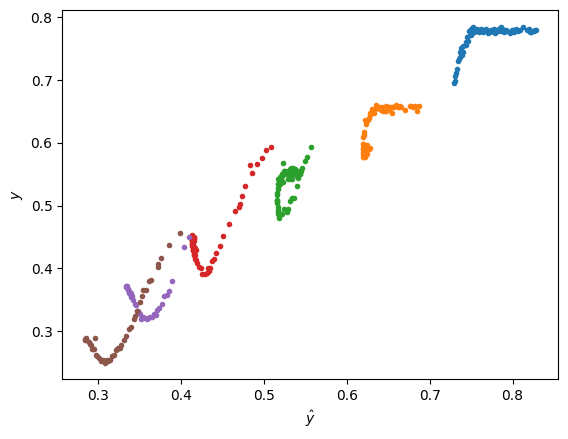

In [5]:
egfinal = Reggression(dataset="nikuradse_1.csv", loadFrom="final.egraph")
df = egfinal.top(5)
plot_error_seg(df, X, y)

In [9]:
egfinal.set_simple_output(True)
modulars = egfinal.modularity(5, filters=["> 5"])

def full_width_formatter(text):
    return text
    
modulars.style.format({'Latex': full_width_formatter})

,Id,Latex,Fitness
0,398,\begin{align}\left(\theta_{0} + \frac{\theta_{1}}{\left(\left(\left(\left(\left(\theta_{2} + r_{k}\right) - f_{0}(\theta_{3})\right) - \frac{\left(f_{0}(\theta_{4}) \cdot \left(r_{k} + r_{k}\right)\right)}{\left(\left(\left(\theta_{5} - r_{k}\right) - r_{k}\right) + r_{k}\right)}\right) \cdot \theta_{6}\right) + \left(log_{Re} + \theta_{7}\right)\right)}\right) \\ f_{0}(\theta) = \left(\left(\left(\theta_{0} + r_{k}\right) + r_{k}\right) - r_{k}\right)\end{align},-0.002686
1,472,\begin{align}\left(\frac{f_{2}(\theta_{0\ldots6})}{\left(\theta_{7} \cdot \left(\left(\left(\left(\theta_{8} - r_{k}\right) + \theta_{9}\right) + r_{k}\right) - r_{k}\right)\right)} - \left(\theta_{10} \cdot f_{2}(\theta_{11\ldots17})\right)\right) \\ f_{0}(\theta) = \left(\left(\left(\theta_{0} + r_{k}\right) + \theta_{1}\right) \cdot \left(r_{k} + r_{k}\right)\right) \\ f_{1}(\theta) = \frac{f_{0}(\theta_{0\ldots1})}{\left(\left(\theta_{2} - r_{k}\right) + \theta_{3}\right)} \\ f_{2}(\theta) = \frac{f_{3}(\theta_{0\ldots2})}{f_{1}(\theta_{3\ldots6})} \\ f_{3}(\theta) = \left(\left(\left(\theta_{0} + r_{k}\right) + \theta_{1}\right) \cdot \theta_{2}\right)\end{align},-0.003646
2,145,\begin{align}\left(\left(f_{7}(\theta_{0\ldots3}) \cdot \left(\left(\left(\left(\left(f_{0}(\theta_{4}) + \left(\theta_{5} \cdot log_{Re}\right)\right) - \left(log_{Re} + log_{Re}\right)\right) + \theta_{6}\right) + 1.0\right) + \left(f_{0}(\theta_{7}) \cdot \theta_{8}\right)\right)\right) - f_{7}(\theta_{9\ldots12})\right) \\ f_{0}(\theta) = \left(\left(\theta_{0} \cdot log_{Re}\right) - \left(log_{Re} + log_{Re}\right)\right) \\ f_{1}(\theta) = \left(\frac{\theta_{0}}{\left(\theta_{1} \cdot log_{Re}\right)} - r_{k}\right) \\ f_{2}(\theta) = \left(f_{1}(\theta_{0\ldots1}) \cdot \left(log_{Re} + log_{Re}\right)\right) \\ f_{3}(\theta) = \frac{f_{0}(\theta_{0})}{f_{2}(\theta_{1\ldots2})} \\ f_{4}(\theta) = \left(f_{3}(\theta_{0\ldots2}) + log_{Re}\right) \\ f_{5}(\theta) = \left(f_{4}(\theta_{0\ldots2}) + log_{Re}\right) \\ f_{6}(\theta) = \left(f_{5}(\theta_{0\ldots2}) + \theta_{3}\right) \\ f_{7}(\theta) = \left(f_{6}(\theta_{0\ldots3}) + \left(log_{Re} + log_{Re}\right)\right)\end{align},-0.004223
3,533,\begin{align}\left(\frac{f_{2}(\theta_{0\ldots4})}{\left(\theta_{5} - r_{k}\right)} - f_{2}(\theta_{6\ldots10})\right) \\ f_{0}(\theta) = \left(f_{3}(\theta_{0\ldots1}) \cdot \left(r_{k} + r_{k}\right)\right) \\ f_{1}(\theta) = \frac{\left(\left(\theta_{0} + r_{k}\right) \cdot \theta_{1}\right)}{f_{0}(\theta_{2\ldots3})} \\ f_{2}(\theta) = \left(f_{1}(\theta_{0\ldots3}) \cdot \theta_{4}\right) \\ f_{3}(\theta) = \frac{\left(\theta_{0} + r_{k}\right)}{\left(\theta_{1} - r_{k}\right)}\end{align},-0.004992
4,147,\begin{align}\frac{\left(\theta_{0} - f_{14}(\theta_{1\ldots9})\right)}{\left(\theta_{10} - \left(f_{14}(\theta_{11\ldots19}) - f_{13}(\theta_{20\ldots23})\right)\right)} \\ f_{0}(\theta) = \left(\left(\theta_{0} \cdot log_{Re}\right) - \left(log_{Re} + log_{Re}\right)\right) \\ f_{1}(\theta) = \left(f_{0}(\theta_{0}) + \left(\theta_{1} \cdot log_{Re}\right)\right) \\ f_{2}(\theta) = \left(f_{1}(\theta_{0\ldots1}) - \left(log_{Re} + log_{Re}\right)\right) \\ f_{3}(\theta) = \left(f_{2}(\theta_{0\ldots1}) + \theta_{2}\right) \\ f_{4}(\theta) = \left(f_{3}(\theta_{0\ldots2}) + 1.0\right) \\ f_{5}(\theta) = \left(f_{0}(\theta_{0}) \cdot \theta_{1}\right) \\ f_{6}(\theta) = \left(f_{4}(\theta_{0\ldots2}) + f_{5}(\theta_{3\ldots4})\right) \\ f_{7}(\theta) = \left(\frac{\theta_{0}}{\left(\theta_{1} \cdot log_{Re}\right)} - r_{k}\right) \\ f_{8}(\theta) = \left(f_{7}(\theta_{0\ldots1}) \cdot \left(log_{Re} + log_{Re}\right)\right) \\ f_{9}(\theta) = \frac{f_{0}(\theta_{0})}{f_{8}(\theta_{1\ldots2})} \\ f_{10}(\theta) = \left(f_{9}(\theta_{0\ldots2}) + log_{Re}\right) \\ f_{11}(\theta) = \left(f_{10}(\theta_{0\ldots2}) + log_{Re}\right) \\ f_{12}(\theta) = \left(f_{11}(\theta_{0\ldots2}) + \theta_{3}\right) \\ f_{13}(\theta) = \left(f_{12}(\theta_{0\l

In [6]:
egfinal.eqsat()

""


In [7]:
egfinal.set_simple_output(True)
modulars = egfinal.modularity(5, filters=["> 4"])
modulars.style.format(reggfmt)

,Id,Latex,Fitness
0,472,\begin{align}\left(\frac{f_{4}(\theta_{0\ldots6})}{\left(\theta_{7} \cdot \left(\left(f_{2}(\theta_{8\ldots9}) + r_{k}\right) - r_{k}\right)\right)} - \left(\theta_{10} \cdot f_{4}(\theta_{11\ldots17})\right)\right) \\ f_{0}(\theta) = \left(\left(\theta_{0} + r_{k}\right) + \theta_{1}\right) \\ f_{1}(\theta) = \left(f_{0}(\theta_{0\ldots1}) \cdot \left(r_{k} + r_{k}\right)\right) \\ f_{2}(\theta) = \left(\left(\theta_{0} - r_{k}\right) + \theta_{1}\right) \\ f_{3}(\theta) = \frac{f_{1}(\theta_{0\ldots1})}{f_{2}(\theta_{2\ldots3})} \\ f_{4}(\theta) = \frac{f_{5}(\theta_{0\ldots2})}{f_{3}(\theta_{3\ldots6})} \\ f_{5}(\theta) = \left(f_{0}(\theta_{0\ldots1}) \cdot \theta_{2}\right)\end{align},-3.65e-03
1,487,\begin{align}\frac{\frac{\left(f_{0}(\theta_{0\ldots1}) \cdot \theta_{2}\right)}{\frac{\left(f_{0}(\theta_{3\ldots4}) \cdot \left(r_{k} + r_{k}\right)\right)}{\left(\left(\theta_{5} - r_{k}\right) + \theta_{6}\right)}}}{\theta_{7}} \\ f_{0}(\theta) = \left(\left(\theta_{0} + r_{k}\right) + \theta_{1}\right)\end{align},-3.80e-03
2,465,\begin{align}\frac{\left(f_{0}(\theta_{0\ldots1}) \cdot \theta_{2}\right)}{\frac{\left(f_{0}(\theta_{3\ldots4}) \cdot \left(r_{k} + r_{k}\right)\right)}{\left(\left(\theta_{5} - r_{k}\right) + \theta_{6}\right)}} \\ f_{0}(\theta) = \left(\left(\theta_{0} + r_{k}\right) + \theta_{1}\right)\end{align},-3.81e-03
3,471,\begin{align}\left(\theta_{0} \cdot \frac{\left(f_{0}(\theta_{1\ldots2}) \cdot \theta_{3}\right)}{\frac{\left(f_{0}(\theta_{4\ldots5}) \cdot \left(r_{k} + r_{k}\right)\right)}{\left(\left(\theta_{6} - r_{k}\right) + \theta_{7}\right)}}\right) \\ f_{0}(\theta) = \left(\left(\theta_{0} + r_{k}\right) + \theta_{1}\right)\end{align},-3.90e-03
4,145,\begin{align}\left(\left(f_{7}(\theta_{0\ldots3}) \cdot \left(\left(\left(\left(\left(f_{0}(\theta_{4}) + \left(\theta_{5} \cdot log_{Re}\right)\right) - \left(log_{Re} + log_{Re}\right)\right) + \theta_{6}\right) + 1.0\right) + \left(f_{0}(\theta_{7}) \cdot \theta_{8}\right)\right)\right) - f_{7}(\theta_{9\ldots12})\right) \\ f_{0}(\theta) = \left(\left(\theta_{0} \cdot log_{Re}\right) - \left(log_{Re} + log_{Re}\right)\right) \\ f_{1}(\theta) = \left(f_{8}(\theta_{0\ldots1}) - r_{k}\right) \\ f_{2}(\theta) = \left(f_{1}(\theta_{0\ldots1}) \cdot \left(log_{Re} + log_{Re}\right)\right) \\ f_{3}(\theta) = \frac{f_{0}(\theta_{0})}{f_{2}(\theta_{1\ldots2})} \\ f_{4}(\theta) = \left(f_{3}(\theta_{0\ldots2}) + log_{Re}\right) \\ f_{5}(\theta) = \left(f_{4}(\theta_{0\ldots2}) + log_{Re}\right) \\ f_{6}(\theta) = \left(f_{5}(\theta_{0\ldots2}) + \theta_{3}\right) \\ f_{7}(\theta) = \left(f_{6}(\theta_{0\ldots3}) + \left(log_{Re} + log_{Re}\right)\right) \\ f_{8}(\theta) = \frac{\theta_{0}}{\left(\theta_{1} \cdot log_{Re}\right)}\end{align},-4.22e-03
